<span style="color:#000000; font-size:1.2em; text-align:right">Data Scientist II Technical Challenge</span>

<span style="color:#e01760; font-size:2em; align=center">Task 4: Real-world Scenario</span>

<font color="#6E6E6E" align="center">Cristina M. Sánchez Maíz | csmaiz@gmail.com | [LinkedIn](https://www.linkedin.com/in/csmaiz/) </font> 

**Tasks:** 

Consider the following business problem:
Your company wants to improve customer satisfaction by understanding the main topics and sentiments expressed in customer reviews. Your task is to:
- Use topic modeling to identify the main topics in the customer reviews.
- Summarize the findings and suggest actionable insights for business improvements. 

**Deliverables:**
- Explanation of the topic modeling process.
- Summary of the main topics identified.
- Actionable insights based on the analysis.

# Import libraries

In [13]:
# Libraries for NLP
import re
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns



from IPython.display import display, HTML


import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import Phrases, LdaModel
from gensim.utils import simple_preprocess

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve


import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [14]:
pd.set_option('display.max_colwidth', None) # avoid truncate columns content

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))


# Load dataset


In [25]:
df = pd.read_csv("../output/Task3/reviews_with_scores.csv",delimiter=",")
df.head(10)

,review_text,preprocessed_review,vader_label,vader_label_3categ,bert_score,bert_label,bert_label_3categ
0,"Terrible service, will not buy from here again.",terrible service buy,negative,negative,0.001188,negative,negative
1,"Average quality, you get what you pay for.",average quality get pay,negative,neutral,0.591803,positive,positive
2,"Great product, very satisfied with the quality and performance.",great product satisfied quality performance,positive,positive,0.999857,positive,positive
3,"Very disappointed with the product, not as described.",disappointed product described,negative,negative,0.000211,negative,negative
4,"Excellent service, highly recommend!",excellent service highly recommend,positive,positive,0.999873,positive,positive
5,The item arrived damaged and customer service was unhelpful.,item arrived damaged customer service unhelpful,negative,negative,0.000206,negative,negative
6,Fast delivery and the product works perfectly!,fast delivery product work perfectly,positive,positive,0.999871,positive,positive
7,The item arrived damaged and customer service was unhelpful.,item arrived damaged customer service unhelpful,negative,negative,0.000206,negative,negative
8,"The service was acceptable, but could be improved.",service acceptable could improved,positive,positive,0.028429,negative,neutral
9,"Decent product, but there are better options available.",decent product better option available,positive,positive,0.979263,positive,positive


In [26]:
df[["review_text", "vader_label", "vader_label_3categ", "bert_label", "bert_label_3categ", "bert_score"]].drop_duplicates()

,review_text,vader_label,vader_label_3categ,bert_label,bert_label_3categ,bert_score
0,"Terrible service, will not buy from here again.",negative,negative,negative,negative,0.001188
1,"Average quality, you get what you pay for.",negative,neutral,positive,positive,0.591803
2,"Great product, very satisfied with the quality and performance.",positive,positive,positive,positive,0.999857
3,"Very disappointed with the product, not as described.",negative,negative,negative,negative,0.000211
4,"Excellent service, highly recommend!",positive,positive,positive,positive,0.999873
5,The item arrived damaged and customer service was unhelpful.,negative,negative,negative,negative,0.000206
6,Fast delivery and the product works perfectly!,positive,positive,positive,positive,0.999871
8,"The service was acceptable, but could be improved.",positive,positive,negative,neutral,0.028429
9,"Decent product, but there are better options available.",positive,positive,positive,positive,0.979263
12,"Poor quality, would not recommend.",negative,negative,negative,negative,0.000832


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           980 non-null    int64  
 1   review_text          980 non-null    object 
 2   preprocessed_review  980 non-null    object 
 3   vader_label          980 non-null    object 
 4   bert_score           980 non-null    float64
 5   bert_label           980 non-null    object 
 6   bert_label_3categ    980 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 53.7+ KB


# Topic Modeling

## LDA

In [67]:




#df_negative = df[df["bert_label_3categ"] == "negative"].drop_duplicates(["review_text"])
df_negative = df[df["vader_label_3categ"] == "negative"].copy()

df_negative["tokens"] = df_negative['preprocessed_review'].apply(lambda pp: pp.split(" "))


def run_LDA(df, num_topics):

    

    id2word = Dictionary(df["tokens"])
    #id2word.filter_extremes(no_below=2, no_above=1.0)
    print(id2word)

    corpus = [id2word.doc2bow(text) for text in df["tokens"]]

    # Train the LDA model
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=3)

    for idx, topic in lda_model.print_topics(num_topics=num_topics, num_words=5):
        print(f"Topic {idx}: {topic}")
        
    return lda_model, corpus, id2word



In [68]:
lda_model, corpus, id2word = run_LDA(df_negative, num_topics=4)

Dictionary<19 unique tokens: ['buy', 'service', 'terrible', 'described', 'disappointed']...>
Topic 0: 0.102*"unhelpful" + 0.102*"arrived" + 0.102*"damaged" + 0.102*"item" + 0.102*"customer"
Topic 1: 0.314*"product" + 0.303*"described" + 0.302*"disappointed" + 0.013*"broke" + 0.012*"use"
Topic 2: 0.197*"use" + 0.197*"one" + 0.196*"unhappy" + 0.196*"broke" + 0.196*"product"
Topic 3: 0.298*"service" + 0.297*"terrible" + 0.297*"buy" + 0.032*"disappointed" + 0.031*"product"


In [69]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.display(LDAvis_prepared)

In [70]:
def get_dominant_topic(lda_model, corpus):
    """
    Determines the dominant topic for a given document.

    Args:
        lda_model: Trained LDA model.
        corpus: Document-term matrix.

    Returns:
        Dominant topic number.
    """
    topic_dist = lda_model[corpus]
    dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
    return dominant_topic


def get_topic_dist(lda_model, corpus):
    """
    Determines the dominant topic for a given document.

    Args:
        lda_model: Trained LDA model.
        corpus: Document-term matrix.

    Returns:
        Dominant topic number.
    """
    topic_dist = lda_model[corpus]
    return topic_dist



def assign_topics_by_lambda(lda_model, doc_term_matrix, lambda_value):
    '''
    Assigns topics to documents based on a lambda threshold.

    Args:
    lda_model: Trained LDA model.
    doc_term_matrix: Document-term matrix.
    lambda_value: Threshold for topic probability.

    Returns:
    List of assigned topics for each document.
    '''

    topic_dist = lda_model[doc_term_matrix]
    relevant_topics = [(topic_id, prob) for topic_id, prob in topic_dist if prob >= lambda_value]

    if relevant_topics:
        # Sort by probability in descending order
        relevant_topics.sort(key=lambda x: x[1], reverse=True)
        return relevant_topics[0][0]  # Return the topic index with the highest probability
    else:
        return -1  # No topic meets the lambda threshold


# Example usage:
lambda_threshold = 0.7

df_negative['topic_dist'] = df_negative['tokens'].apply(lambda x: get_topic_dist(lda_model, id2word.doc2bow(x)))

df_negative['topic_number'] = df_negative['tokens'].apply(lambda x: get_dominant_topic(lda_model, id2word.doc2bow(x)))
df_negative['topic_number_lambda'] = df_negative['tokens'].apply(lambda x: assign_topics_by_lambda(lda_model, id2word.doc2bow(x), lambda_value=lambda_threshold))

df_negative
df_negative[["review_text", "topic_number", "topic_number_lambda", "topic_dist"]].drop_duplicates(["review_text", "topic_number", "topic_number_lambda"])

,review_text,topic_number,topic_number_lambda,topic_dist
0,"Terrible service, will not buy from here again.",3,3,"[(0, 0.06296748), (1, 0.062506035), (2, 0.062502295), (3, 0.81202424)]"
3,"Very disappointed with the product, not as described.",1,1,"[(0, 0.0625008), (1, 0.81122273), (2, 0.06337944), (3, 0.062897064)]"
5,The item arrived damaged and customer service was unhelpful.,0,0,"[(0, 0.89159095), (1, 0.035720736), (2, 0.035716794), (3, 0.036971502)]"
12,"Poor quality, would not recommend.",0,0,"[(0, 0.84996665), (1, 0.050010674), (2, 0.050018113), (3, 0.050004583)]"
15,"The product broke after one use, very unhappy.",2,2,"[(0, 0.041667324), (1, 0.042677123), (2, 0.8739097), (3, 0.041745853)]"


In [71]:
lambd = 0.2 # a specific relevance metric value

all_topics = {}
num_topics = lda_model.num_topics 
num_terms = 10 

for i in range(1,num_topics+1): ## Correct range
    topic = LDAvis_prepared.topic_info[LDAvis_prepared.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    display(topic)
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
pd.DataFrame(all_topics)





,Term,Freq,Total,Category,logprob,loglift,relevance
10,unhelpful,64.805060,65.773994,Topic1,-2.2874,0.7423,0.13636
6,arrived,64.804018,65.773796,Topic1,-2.2874,0.7423,0.13636
7,customer,64.796129,65.773976,Topic1,-2.2875,0.7422,0.13626
9,item,64.798601,65.776520,Topic1,-2.2875,0.7422,0.13626
8,damaged,64.799239,65.777452,Topic1,-2.2875,0.7422,0.13626
12,quality,61.798618,63.033899,Topic1,-2.3349,0.7374,0.12294
11,poor,61.786463,63.034418,Topic1,-2.3351,0.7372,0.12274
13,recommend,61.725638,63.047502,Topic1,-2.3361,0.7360,0.12158
14,would,61.715090,63.060299,Topic1,-2.3363,0.7356,0.12122
1,service,64.648485,138.475240,Topic1,-2.2898,-0.0045,-0.46156


,Term,Freq,Total,Category,logprob,loglift,relevance
16,one,60.909768,63.529065,Topic2,-1.6270,1.4374,0.82452
18,use,60.910008,63.531636,Topic2,-1.6270,1.4374,0.82452
17,unhappy,60.888846,63.526175,Topic2,-1.6274,1.4371,0.82420
15,broke,60.865692,63.534951,Topic2,-1.6278,1.4366,0.82372
5,product,60.836982,121.624217,Topic2,-1.6282,0.7868,0.30380
13,recommend,0.572991,63.047502,Topic2,-6.2933,-3.2212,-3.83562
14,would,0.566880,63.060299,Topic2,-6.3040,-3.2322,-3.84656
11,poor,0.553038,63.034418,Topic2,-6.3288,-3.2565,-3.87096
12,quality,0.552326,63.033899,Topic2,-6.3300,-3.2577,-3.87216
4,disappointed,0.337999,59.093162,Topic2,-6.8211,-3.6843,-4.31166


,Term,Freq,Total,Category,logprob,loglift,relevance
2,terrible,72.655932,73.750384,Topic3,-1.2147,1.7005,1.11746
0,buy,72.623932,73.766430,Topic3,-1.2152,1.6999,1.11688
1,service,72.901847,138.475240,Topic3,-1.2114,1.0739,0.61684
4,disappointed,7.717899,59.093162,Topic3,-3.4569,-0.3201,-0.94746
3,described,7.649261,59.116928,Topic3,-3.4659,-0.3294,-0.95670
5,product,7.694209,121.624217,Topic3,-3.4600,-1.0450,-1.52800
13,recommend,0.304763,63.047502,Topic3,-6.6887,-3.6166,-4.23102
14,would,0.291412,63.060299,Topic3,-6.7335,-3.6616,-4.27598
11,poor,0.286202,63.034418,Topic3,-6.7515,-3.6792,-4.29366
12,quality,0.276299,63.033899,Topic3,-6.7867,-3.7144,-4.32886


,Term,Freq,Total,Category,logprob,loglift,relevance
3,described,50.841499,59.116928,Topic4,-1.1949,1.9415,1.31422
4,disappointed,50.765681,59.093162,Topic4,-1.1964,1.9404,1.31304
5,product,52.758388,121.624217,Topic4,-1.1579,1.2571,0.77410
15,broke,2.122207,63.534951,Topic4,-4.3712,-1.3068,-1.91968
18,use,2.093813,63.531636,Topic4,-4.3847,-1.3202,-1.93310
16,one,2.085573,63.529065,Topic4,-4.3886,-1.3241,-1.93700
17,unhappy,2.085095,63.526175,Topic4,-4.3888,-1.3243,-1.93720
14,would,0.486917,63.060299,Topic4,-5.8433,-2.7714,-3.38578
13,recommend,0.444110,63.047502,Topic4,-5.9353,-2.8632,-3.47762
11,poor,0.408715,63.034418,Topic4,-6.0184,-2.9461,-3.56056


,Topic 1,Topic 2,Topic 3,Topic 4
0,unhelpful,one,terrible,described
1,arrived,use,buy,disappointed
2,customer,unhappy,service,product
3,item,broke,disappointed,broke
4,damaged,product,described,use
5,quality,recommend,product,one
6,poor,would,recommend,unhappy
7,recommend,poor,would,would
8,would,quality,poor,recommend
9,service,disappointed,quality,buy


In [72]:
for cluster in range(0,num_topics):
    print(f"Cluster {cluster}:")
    for review in df_negative[df_negative['topic_number'] == cluster]['review_text'].unique():
        print(f" - {review}")

Cluster 0:
 - The item arrived damaged and customer service was unhelpful.
 - Poor quality, would not recommend.
Cluster 1:
 - Very disappointed with the product, not as described.
Cluster 2:
 - The product broke after one use, very unhappy.
Cluster 3:
 - Terrible service, will not buy from here again.


Dataset size and characteristics: Large datasets might benefit from scalable methods like Non-Negative Matrix Factorization (NMF).

Desired number of topics: If you need a predetermined number of topics, LDA might be suitable.

Interpretability: For easily understandable topics, LDA often works well.

Based on the topic-sentiment analysis, you can:

- Identify topics with high negative sentiment: Focus on improving these areas.
- Analyze topics with high positive sentiment: Leverage these strengths.
- Compare topics over time: Detect trends and emerging issues.
- Correlate topics with customer demographics: Identify specific customer segments.

Note:

This is a basic example. You might need to adjust parameters (number of topics, preprocessing steps, etc.) based on your dataset.
Consider using more advanced topic modeling techniques like Non-Negative Matrix Factorization (NMF) or Latent Semantic Analysis (LSA).
For deeper sentiment analysis, explore fine-grained sentiment classification or aspect-based sentiment analysis.
By combining topic modeling and sentiment analysis, you can gain valuable insights into customer feedback and drive business improvements.

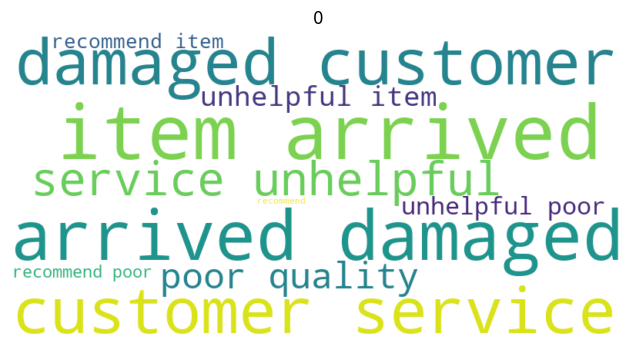

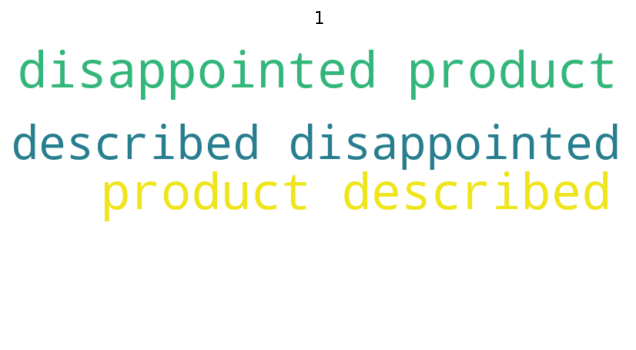

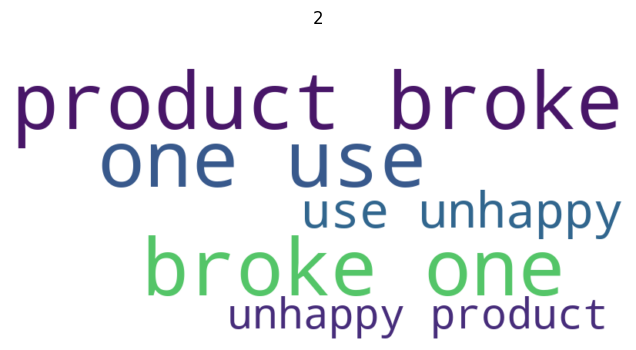

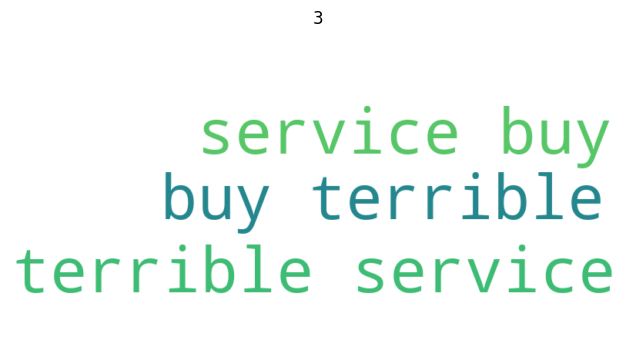

In [73]:
from wordcloud import WordCloud

# Create word clouds for each topic
for topic, reviews in df_negative.groupby('topic_number'):
    text = ' '.join(reviews['preprocessed_review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(topic)

    plt.show()

## Large language model

In [ ]:
import os
os.environ["http_proxy"]=""
os.environ["https_proxy"]=""

In [74]:
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np
import torch
from transformers import DistilBertTokenizer, DistilBertModel


# Code extracted from Hugging face web - https://huggingface.co/distilbert/distilbert-base-uncased
# Load pre-trained model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

'''
Function to get embeddings for a list of texts
function tokenizes the input texts, generates embeddings using a pre-trained model, 
and averages the token embeddings to produce a single vector representation for each document.
''' 
def get_embeddings(texts, model, tokenizer):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

# Generate embeddings for the reviews
embeddings = get_embeddings(df['review_text'].tolist(), model, tokenizer)



,review_text,preprocessed_review,vader_label,vader_label_3categ,bert_score,bert_label,bert_label_3categ
0,"Terrible service, will not buy from here again.",terrible service buy,negative,negative,0.001188,negative,negative
3,"Very disappointed with the product, not as described.",disappointed product described,negative,negative,0.000211,negative,negative
5,The item arrived damaged and customer service was unhelpful.,item arrived damaged customer service unhelpful,negative,negative,0.000206,negative,negative
12,"Poor quality, would not recommend.",poor quality would recommend,negative,negative,0.000832,negative,negative
15,"The product broke after one use, very unhappy.",product broke one use unhappy,negative,negative,0.000230,negative,negative


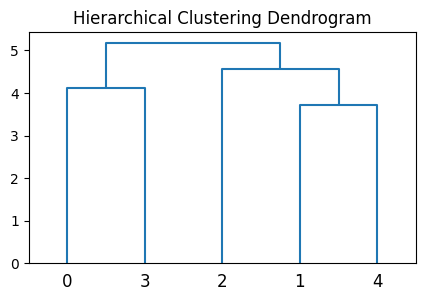

In [75]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt


df_negative = df[df["vader_label_3categ"].isin(["negative"])].drop_duplicates(["review_text"])
display(df_negative)

# Remove duplicate reviews before running the clustering since duplicate reviews 
# can skew the clustering results by giving more weight to the repeated texts
#df_unique = df_negative.drop_duplicates(subset=['review_text'])[["review_text"]]

embeddings = get_embeddings(df_negative['review_text'].tolist(), model, tokenizer)

# Apply Hierarchical Clustering
hierarchical_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hierarchical_cluster.fit(embeddings)

# Create the linkage matrix
Z = linkage(embeddings, 'ward')


# Plot the dendrogram
plt.figure(figsize=(5, 3))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(Z)
plt.show()





In [76]:
# Decide the number of clusters by cutting the dendrogram
num_clusters = 4  # Adjust based on the dendrogram
from scipy.cluster.hierarchy import fcluster
labels = fcluster(Z, num_clusters, criterion='maxclust')
df_negative['cluster_label'] = labels


##df.drop("cluster_label",errors='ignore')  

# Merge the cluster labels back to the original dataframe
##df = pd.merge(df, df_unique[['review_text', 'cluster_label']], on='review_text', how='left')

# Display the number of documents per cluster
print(df_negative['cluster_label'].value_counts())
df_negative[["review_text", "cluster_label"]].drop_duplicates()



cluster_label
1    2
2    2
3    1
Name: count, dtype: int64


,review_text,cluster_label
0,"Terrible service, will not buy from here again.",1
3,"Very disappointed with the product, not as described.",2
5,The item arrived damaged and customer service was unhelpful.,3
12,"Poor quality, would not recommend.",1
15,"The product broke after one use, very unhappy.",2


In [77]:
for cluster in range(1,num_clusters+1):
    print(f"Cluster {cluster}:")
    for review in df_negative[df_negative['cluster_label'] == cluster]['review_text'].unique():
        print(f" - {review}")

Cluster 1:
 - Terrible service, will not buy from here again.
 - Poor quality, would not recommend.
Cluster 2:
 - Very disappointed with the product, not as described.
 - The product broke after one use, very unhappy.
Cluster 3:
 - The item arrived damaged and customer service was unhelpful.
Cluster 4:


### Comments


Cluster 1:
 - Terrible service, will not buy from here again.
 - Poor quality, would not recommend.
 
Cluster 2:
 - Very disappointed with the product, not as described.
 - The product broke after one use, very unhappy.

Cluster 3:
 - The item arrived damaged and customer service was unhelpful.

Cluster 4:
 - The product works fine, but took a long time to arrive.

- Cluster 1 
   * corresponds to the customers who won't recommend buying again --> DETRACTORS
- Cluster 2:
   * Product Quality issues
   * Negative Feedback on Product Description
- Cluster 3:
  * Customer service issues
- Cluster 4:
  * Delivery and Shipping Issues


### Actionable insights based on the analysis.

Based on the identified topics and sentiments, here are some actionable insights for the business:

**Improve Customer Service:**
- Conduct training sessions for customer service representatives to improve their communication skills and responsiveness.
- Implement a better tracking system for customer inquiries to ensure timely responses.

**Enhance Product Descriptions:**
- Review and update product descriptions to ensure they accurately reflect the product features and quality.
- Include more detailed images and customer reviews to set realistic expectations.

**Address Product Quality Issues:**
- Investigate and address any recurring quality issues in the products.
- Consider quality checks and improvements in the production process.


**Streamline Delivery and Shipping:**
- Partner with reliable shipping companies to ensure timely and accurate deliveries.
- Implement a tracking system for customers to monitor their orders in real-time.


**Leverage Positive Feedback:**
- Highlight positive reviews and testimonials in marketing materials.
- Encourage satisfied customers to leave reviews and share their experiences.

**Focus on Loyalty Programs:**
- Implement or enhance loyalty programs to reward repeat customers.
- Offer exclusive discounts or early access to new products for loyal customers.